In [1]:
using LinearAlgebra
using SparseArrays
using Random
using CairoMakie
using Statistics
using DynamicalSystemsBase
using ProgressMeter
using DataFrames

KeyError: KeyError: key "usage_request" not found

In [2]:
total_time = 100
time_delta = 0.05
ts_str = ["x", "y", "z"]
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10

10

In [3]:
function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

Lorenz (generic function with 1 method)

In [4]:
lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

(3-dimensional StateSpaceSet{Float64} with 2001 points, 10.0:0.05:110.0)

In [5]:
function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

SplitSet (generic function with 1 method)

In [6]:
lo_train, lo_test = SplitSet(lo_tr[:,1], 0.8)

([5.126534053416267, 5.8347074191664605, 6.991808368592087, 8.530218508308034, 10.224320166934305, 11.57926240581935, 11.948150770948311, 11.023255596485084, 9.201794933146939, 7.247977109476569  …  0.8128513950560095, 2.0131689335772176, 2.9306084220910145, 3.9057652575881487, 5.176123312015842, 6.907351756637779, 9.132776004273556, 11.54313642493474, 13.24840575325014, 13.128061744392378], [11.019241140172133, 8.05518613159335, 5.455128280008101, 3.7153568873613363, 2.794128986939801, 2.4924550131197254, 2.6541318734148733, 3.2209649259728663, 4.229858074981418, 5.7874613779010184  …  15.05662606985458, 11.319530094957964, 6.701801500508334, 3.1208599141469695, 0.8949378751920789, -0.37647347812640464, -1.1554793555504739, -1.782626684513485, -2.4934154715086243, -3.4778960764507048])

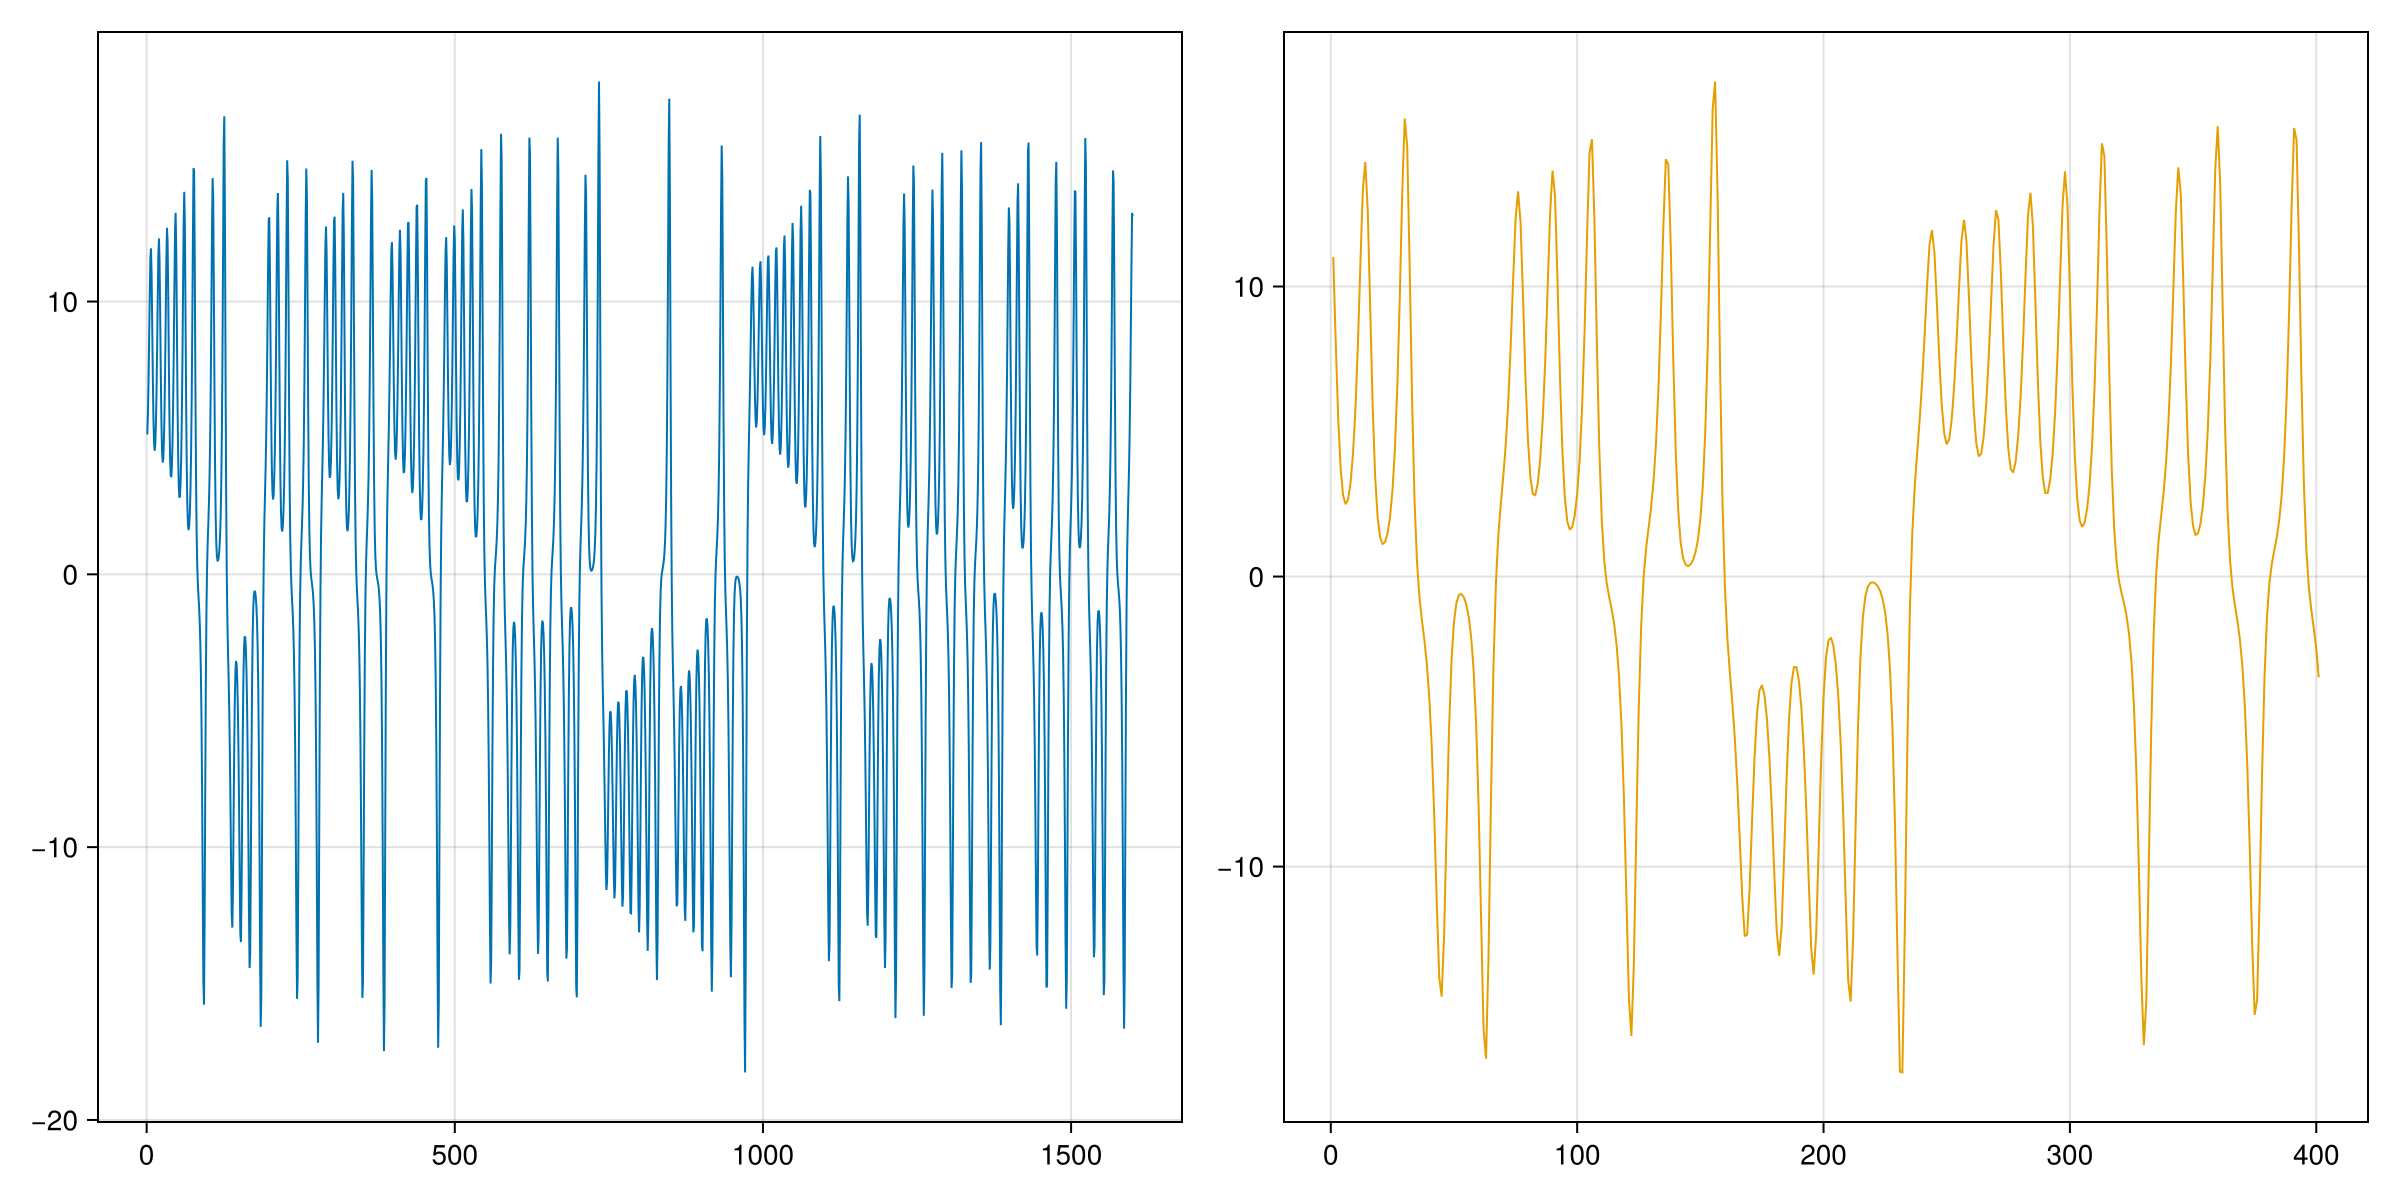

In [7]:
fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [8]:
function erdos_renyi_adjacency(k, d)
    p = d/(k-1)
    adj_mat = triu(collect(sprand(k, k, p)))
    adj_mat = adj_mat + adj_mat'
    adj_mat[diagind(adj_mat)] .= 0
    return(adj_mat)
end

function create_ESN(k, d, ρ)
    V_in = randn(k)
    
    V_rec = erdos_renyi_adjacency(k, d)
    max_abs_ev = maximum(abs.(eigen(V_rec).values))
    V_rec = V_rec * ρ / max_abs_ev
    
    V_bias = randn(k)
    
    return(V_in, V_rec, V_bias)
end

struct ESNParameters
    V_in::Vector{Float64}
    V_rec::Matrix{Float64}
    V_bias::Vector{Float64}
    k::Int64
    α::Float64
    η::Float64
    β::Float64
end

function create_ESN_params(k, d, ρ, α, η, β)
    V_in, V_rec, V_bias = create_ESN(k, d, ρ)
    ESN_params = ESNParameters(V_in, V_rec, V_bias, k, α, η, β)
    
    return(ESN_params)
end

create_ESN_params (generic function with 1 method)

In [11]:
function run_ESN(x, ESN_params; S = nothing)
    if S == nothing
        S = randn(ESN_params.k)
    end
    
    states = zeros(Float64, ESN_params.k, length(x))
    
    for t in 1:length(x)
        S = (1 − ESN_params.α)*S + ESN_params.α*tanh.(
            ESN_params.η*ESN_params.V_in*x[t] + ESN_params.V_rec*S + ESN_params.V_bias)
        states[:, t] = S
    end
    
    return(states')
end

run_ESN (generic function with 1 method)

In [12]:
using LinearAlgebra

function ridge_regression(x::Vector, states::Matrix, beta::Float64)
    # Ensure states is a matrix and x is a vector
    @assert size(states, 1) == length(x)
    
    # Compute the number of features
    n_features = size(states, 2)
    
    # Compute the identity matrix of size n_features
    I_test = Matrix{Float64}(I, n_features, n_features)
    
    # Compute the Ridge regression solution
    R = (states' * states + beta * I_test) \ (states' * x)
    
    return R
end

# Example usage
# states = [1.0 2.0; 3.0 4.0; 5.0 6.0]
# x = [1.0, 2.0, 3.0]
# lambda = 0.1

# R = ridge_regression(x, states, lambda)

ridge_regression (generic function with 1 method)

In [13]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

In [14]:
function calculate_corr_coeffs(ESN_params, max_τ, x_length)
    u_train = randn(x_length)
    u_test = randn(x_length)
    corr_coeffs = zeros(max_τ+1)
    states_train = run_ESN(u_train, ESN_params)
    states_test = run_ESN(u_test, ESN_params)

    for delay in 0:1:max_τ
        # Train an R for remembering the input 'delay' steps ago
        states_train_later = states_train[1+delay:size(states_train)[1],:]
        u_train_earlier = u_train[1:length(u_train)-delay]

        R = ridge_regression(u_train_earlier, states_train_later, ESN_params.β)
        
        states_test_later = states_test[1+delay:size(states_test)[1],:]
        u_test_earlier = u_test[1:length(u_test)-delay]
        
        # Make the recollections
        test_preds = states_test_later * R
        
        # Save errors (as correlation)
        corr_coeffs[delay+1] = cor(u_test_earlier, test_preds)#^2
    end
    
    return(corr_coeffs)
end

calculate_corr_coeffs (generic function with 1 method)

In [15]:
function find_max_delay(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    return(findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ))
end

find_max_delay (generic function with 1 method)

In [16]:
function plot_memory_capacity(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    MCs = cumsum(corr_coeffs)
    
    fig = Figure( size = (1200,600) )
    lines!(Axis(fig[1,1]), corr_coeffs)
    ylims!(-0.1,1.1)
    lines!(Axis(fig[1,2]), MCs)
    ylims!(0,maximum(MCs)+1)
    
    println(string(
        "Memory capacity: ",
        findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ)
    ))
    
    display(fig)
end

plot_memory_capacity (generic function with 1 method)

In [17]:
function one_step_errors(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)

    return(cor(lo_test[2:end], preds[1:length(preds)-1]))
end

one_step_errors (generic function with 1 method)

In [18]:
function plot_one_step_test(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(0,200)
    ylims!(-25,25)
    
    ax1 = Axis(fig[2,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(length(lo_test)-200,length(lo_test))
    ylims!(-25,25)
    display(fig)
    
    println(string("Error (correlation): ", cor(preds[1:end-1], lo_test[2:end])))
end

plot_one_step_test (generic function with 1 method)

In [19]:
k = 5
d = k*0.05
ρ = 1.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

ESNParameters([0.7435304411464839, 1.438297753789429, -0.6183156120790915, -0.6442415686439346, -0.3386691506704799], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [0.051378633835741955, 0.2073870871336124, 1.7052987146954888, -0.8845156823045663, 1.719440767358309], 5, 1.0, 0.0553598532856682, 0.001)

## One-step Prediction, Correlation (error) and Memory Capacity

In [20]:
plot_one_step_test(ESN_params)
plot_memory_capacity(ESN_params, 30, 10000)

LoadError: ArgumentError: matrix contains Infs or NaNs

## Spectral radius vs error (correlation)

In [21]:
plot(collect(0.01:0.01:10.0),
    [one_step_errors(create_ESN_params(k, d, ρ_i, α, η, β)) for ρ_i in 0.01:0.01:10.0])

LoadError: ArgumentError: matrix contains Infs or NaNs

When the spectral radius is low, the correlation of the predicted to the actual trajectory appears to be high (approximately 1). As the spectral radius increases, the correlation drops and becomes more distributed randomly between -1 and 1. The correlation begins to drop between ρ=1 and ρ=2 and appears randomly distributed above around ρ=2.5.

## Spectral radius vs memory capacity

In [22]:
# plot(collect(0.0:0.01:10.0),
#     [find_max_delay(create_ESN_params(k, d, ρ_i, α, η, β), 30, 10000)
#         for ρ_i in 0.0:0.01:10.0])

As the spectral radius increases, the memory capacity generally increases up to around ρ=1.5 to ρ=2, afterwhich it decreases and plateaus around 1 to 6. After around ρ=1, the memory capacity becomes more variable, increasing from range of approximately 3-4 to a range of approximately 15.

## Freerun prediction

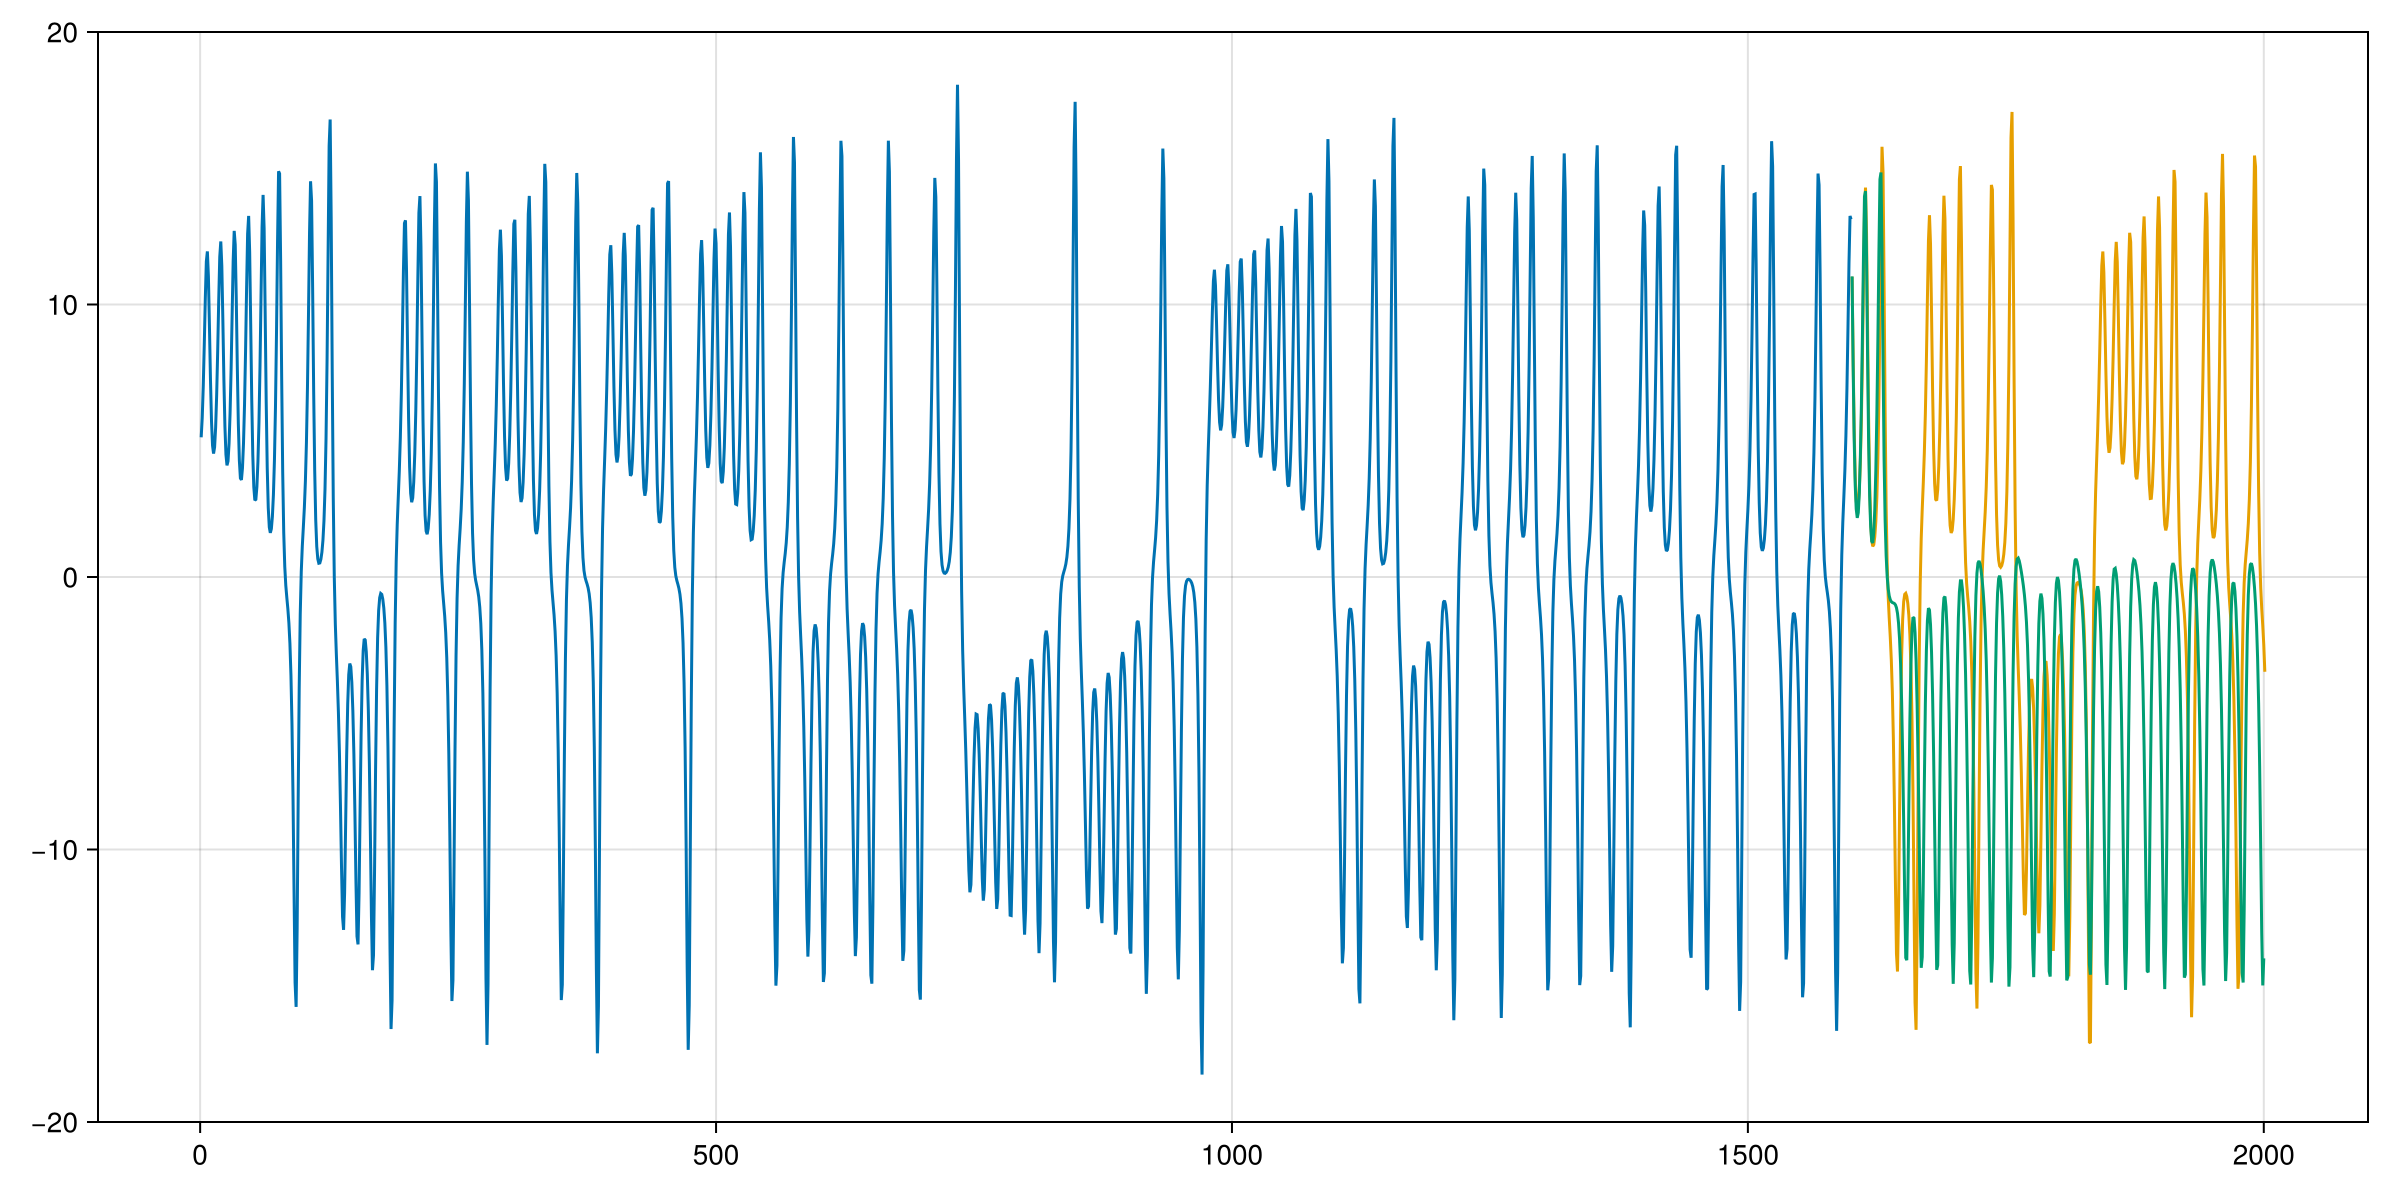

In [23]:
k = 50
d = k*0.05
ρ = 1.1
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)
R, train_states = train_one_step_pred(lo_train, ESN_params)


num_pred_steps = 400

current_state = train_states[end, :]
pred = [lo_train[end]]

preds = zeros(num_pred_steps)

for i in 1:num_pred_steps
    pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)

    current_state = current_state'
    preds[i] = pred[1]
end


fig = Figure( size = (1200,600) )
ax = Axis(fig[1,1])
lines!(ax, lo_train)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(lo_test)-1, lo_test)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(preds)-1, preds)
# xlims!(600,1000)
ylims!(-20,20)
fig

In [24]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

# Ordinal Readout Switching

In [25]:
function create_ordinal_partition(tr, m, w, τ)
    rankings = zeros(Int, trunc(Int, length(tr)/w - τ*(m-1)), m)
    for j in 1:1:trunc(Int, length(tr)/w - τ*(m-1))
        x = w*(j-1) + 1
        rankings[j, :] = sortperm([tr[i] for i in x:τ:(x+τ*(m-1))])
    end
    return(rankings)
end

function find_probs(partition)
    df = DataFrame(partition, :auto)
    counts = combine(groupby(df, names(df)), nrow => :count)
    counts.probability = counts.count ./ sum(counts.count)
    return(counts)
end

find_probs (generic function with 1 method)

In [26]:
function train_one_step_pred_with_mask(x, ESN_params, mask)
    states = run_ESN(x, ESN_params)
    
    target_z = x[[false; mask[1:end-1]]]
    predicted_states = states[1:size(states)[1]-1,:][mask[1:end-1],:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred_partitioned(x, ESN_params, Rs; S = nothing)
    
    
    states = run_ESN(x, ESN_params; S = S)
    preds = states*Rs'
    
    return(preds, states)
end

one_step_pred_partitioned (generic function with 1 method)

In [27]:
function switch_prediction(y, prediction_series, partition_definitions)
    part = create_ordinal_partition(y, m, w, τ)
    part_symbols = [findfirst(==(row), partition_definitions) for row in eachrow(part)]

    switching_prediction = [prediction_series[i, part_symbols[i]] for i in 1:length(part_symbols)]
    
    return(switching_prediction)
end

switch_prediction (generic function with 1 method)

In [68]:
k = 1000
d = k*0.05
ρ = 1.1
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

ESNParameters([0.1274856839455665, -0.4579200967287951, 0.1692788512377207, -0.6494917743609272, 0.8010159249545372, -1.840076737109407, 1.4144886678597695, 0.8874791172911087, 0.6697132109147284, -1.0292769795720629  …  -0.052285329226068045, 1.0664765493246249, 1.2510939759743507, -0.19077405249404625, 1.6639425764373847, 0.91330619803257, -0.2803479575837528, 1.8106335097192232, -2.12598035669372, 0.4912419684525621], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.019281057460253524 0.0; … ; 0.0 0.019281057460253524 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.4706773291076523, 0.7776435400951287, 1.8492402223183346, -0.032906118875399924, -0.6207304947860884, 0.8945004357542684, -1.1695329898427411, -0.4919421676450675, -1.2639835487468016, -0.6140450288216616  …  0.4094802703560763, -0.20200042089563708, -0.7527344133828423, 0.7924669415618185, -0.9885259452523301, 1.7470277417907982, -1.0707700037548313, -0.09215025873149105, 0.6604027855394994, -0.3098662021874336], 1000, 1.0, 0.0553598532856682, 0.01)

In [69]:
m = 3
w = 1
τ = 3

part = create_ordinal_partition(lo_train, m, w, τ)
part_symbols = [findfirst(==(row), unique(eachrow(part))) for row in eachrow(part)]
unique_partitions = unique(eachrow(part))
partition_dict = Dict(i => unique_partitions[i] for i in 1:length(unique_partitions))

Rs = Matrix(undef, length(unique(eachrow(part))), ESN_params.k)  # Initialize an n x 3 matrix for integer vectors

for i in 1:length(unique(eachrow(part)))
    part_mask = [part_symbols .== i; fill(false, 6)]
    R, train_states = train_one_step_pred_with_mask(lo_train, ESN_params, part_mask)
    Rs[i, :] = R
end

preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs)
switching_pred = switch_prediction(lo_test, preds, unique_partitions)

395-element Vector{Float64}:
 23.13980847793423
  5.478582751805984
  4.438577890002128
  3.1066502510612697
  2.267713627058271
  2.5079274174230064
  3.1456678907421183
  4.173421283213155
  5.6690101695815285
  7.994816804032449
 10.80205886001122
 13.410739331855318
 14.303907128574032
  ⋮
  2.012154941497987
  2.868902566833102
  4.145630260362315
  6.282750139579844
  9.082663566601433
 12.728630311021014
 15.312593856954276
 15.035932819908547
 11.359505347257102
  6.642776608574745
  3.115072494549994
  0.889224940016973

In [70]:
R, train_states = train_one_step_pred(lo_train, ESN_params)
preds, test_states = one_step_pred(lo_test, ESN_params, R)

([13.61550416665969, 2.6595629678415307, 3.6132246253533964, 2.624068675027366, 2.4662697747880546, 2.657986365342225, 3.2426102570430215, 4.251422187554456, 5.800526652267049, 8.00410454509586  …  11.370473567061234, 6.659227162385205, 3.1611029867464246, 0.8913836756953231, -0.40731380268220363, -1.167310479194704, -1.799328954468411, -2.5240261426126063, -3.5144920346396367, -4.958029662081719], [0.46451859170502274 0.41903819224092537 … -0.7109468351944932 -0.38800663320505846; 0.5110011777245859 0.5999651160475523 … -0.06832148928851998 -0.2287949133877912; … ; 0.4465582578099723 0.8057349294512091 … 0.7742316973321002 -0.4863372946903246; 0.43985163191149157 0.8159159343392814 … 0.8130225088245668 -0.5080917660858676])

In [71]:
println(cor(preds, lo_test))
println(cor(switching_pred, lo_test[1:length(switching_pred)]))

0.9617805276124657
0.9595915771029262


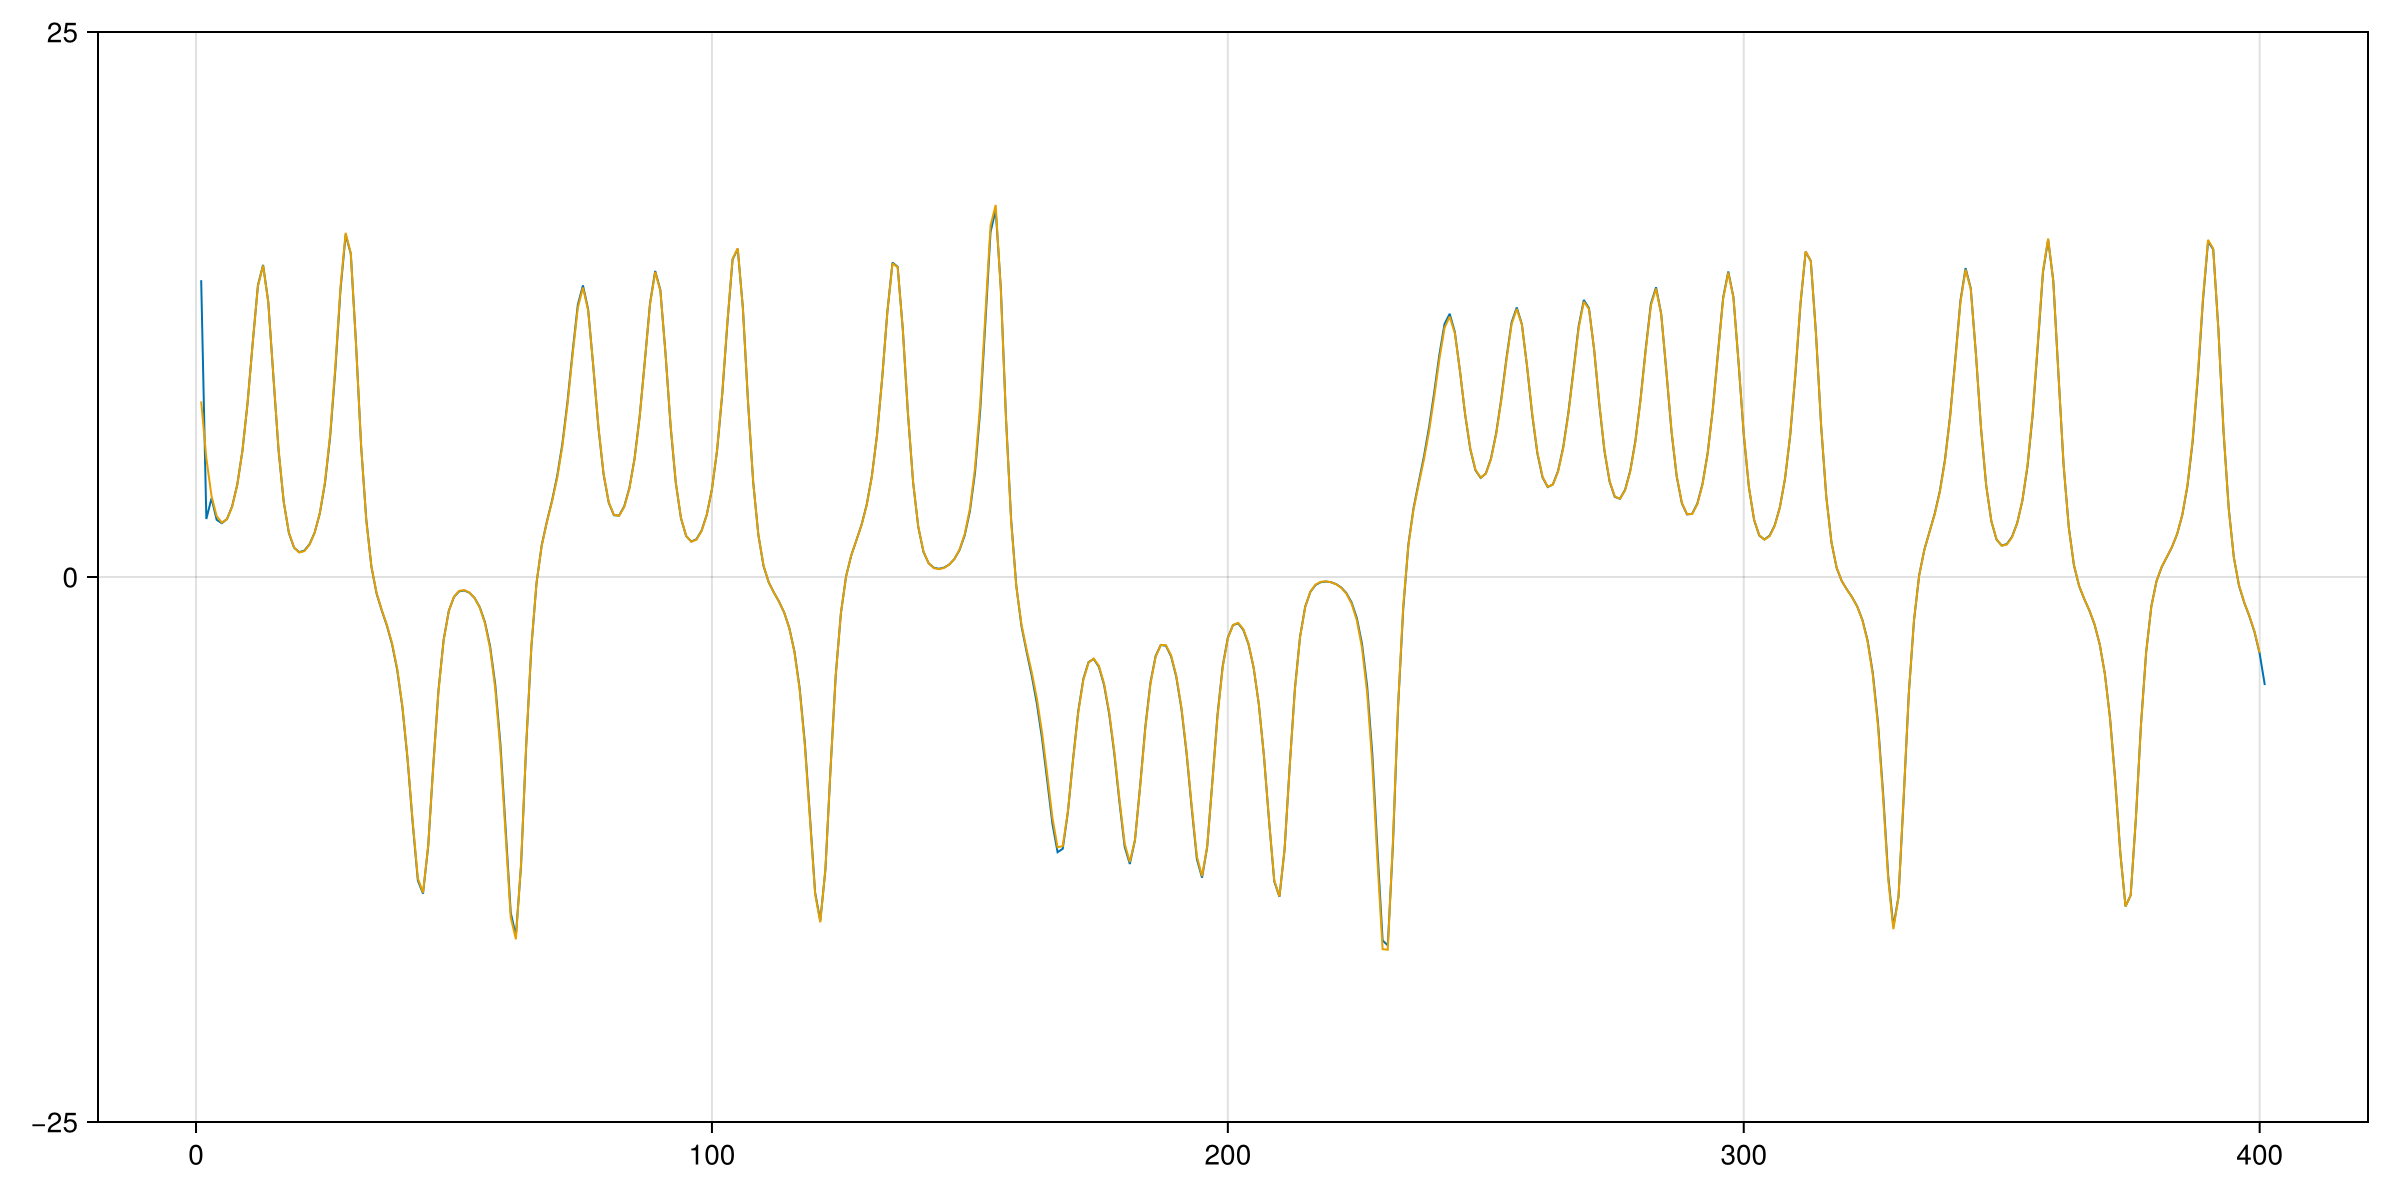

CairoMakie.Screen{IMAGE}


In [72]:
fig = Figure( size = (1200,600) )
ax1 = Axis(fig[1,1])
lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
# xlims!(0,200)
ylims!(-25,25)
display(fig)

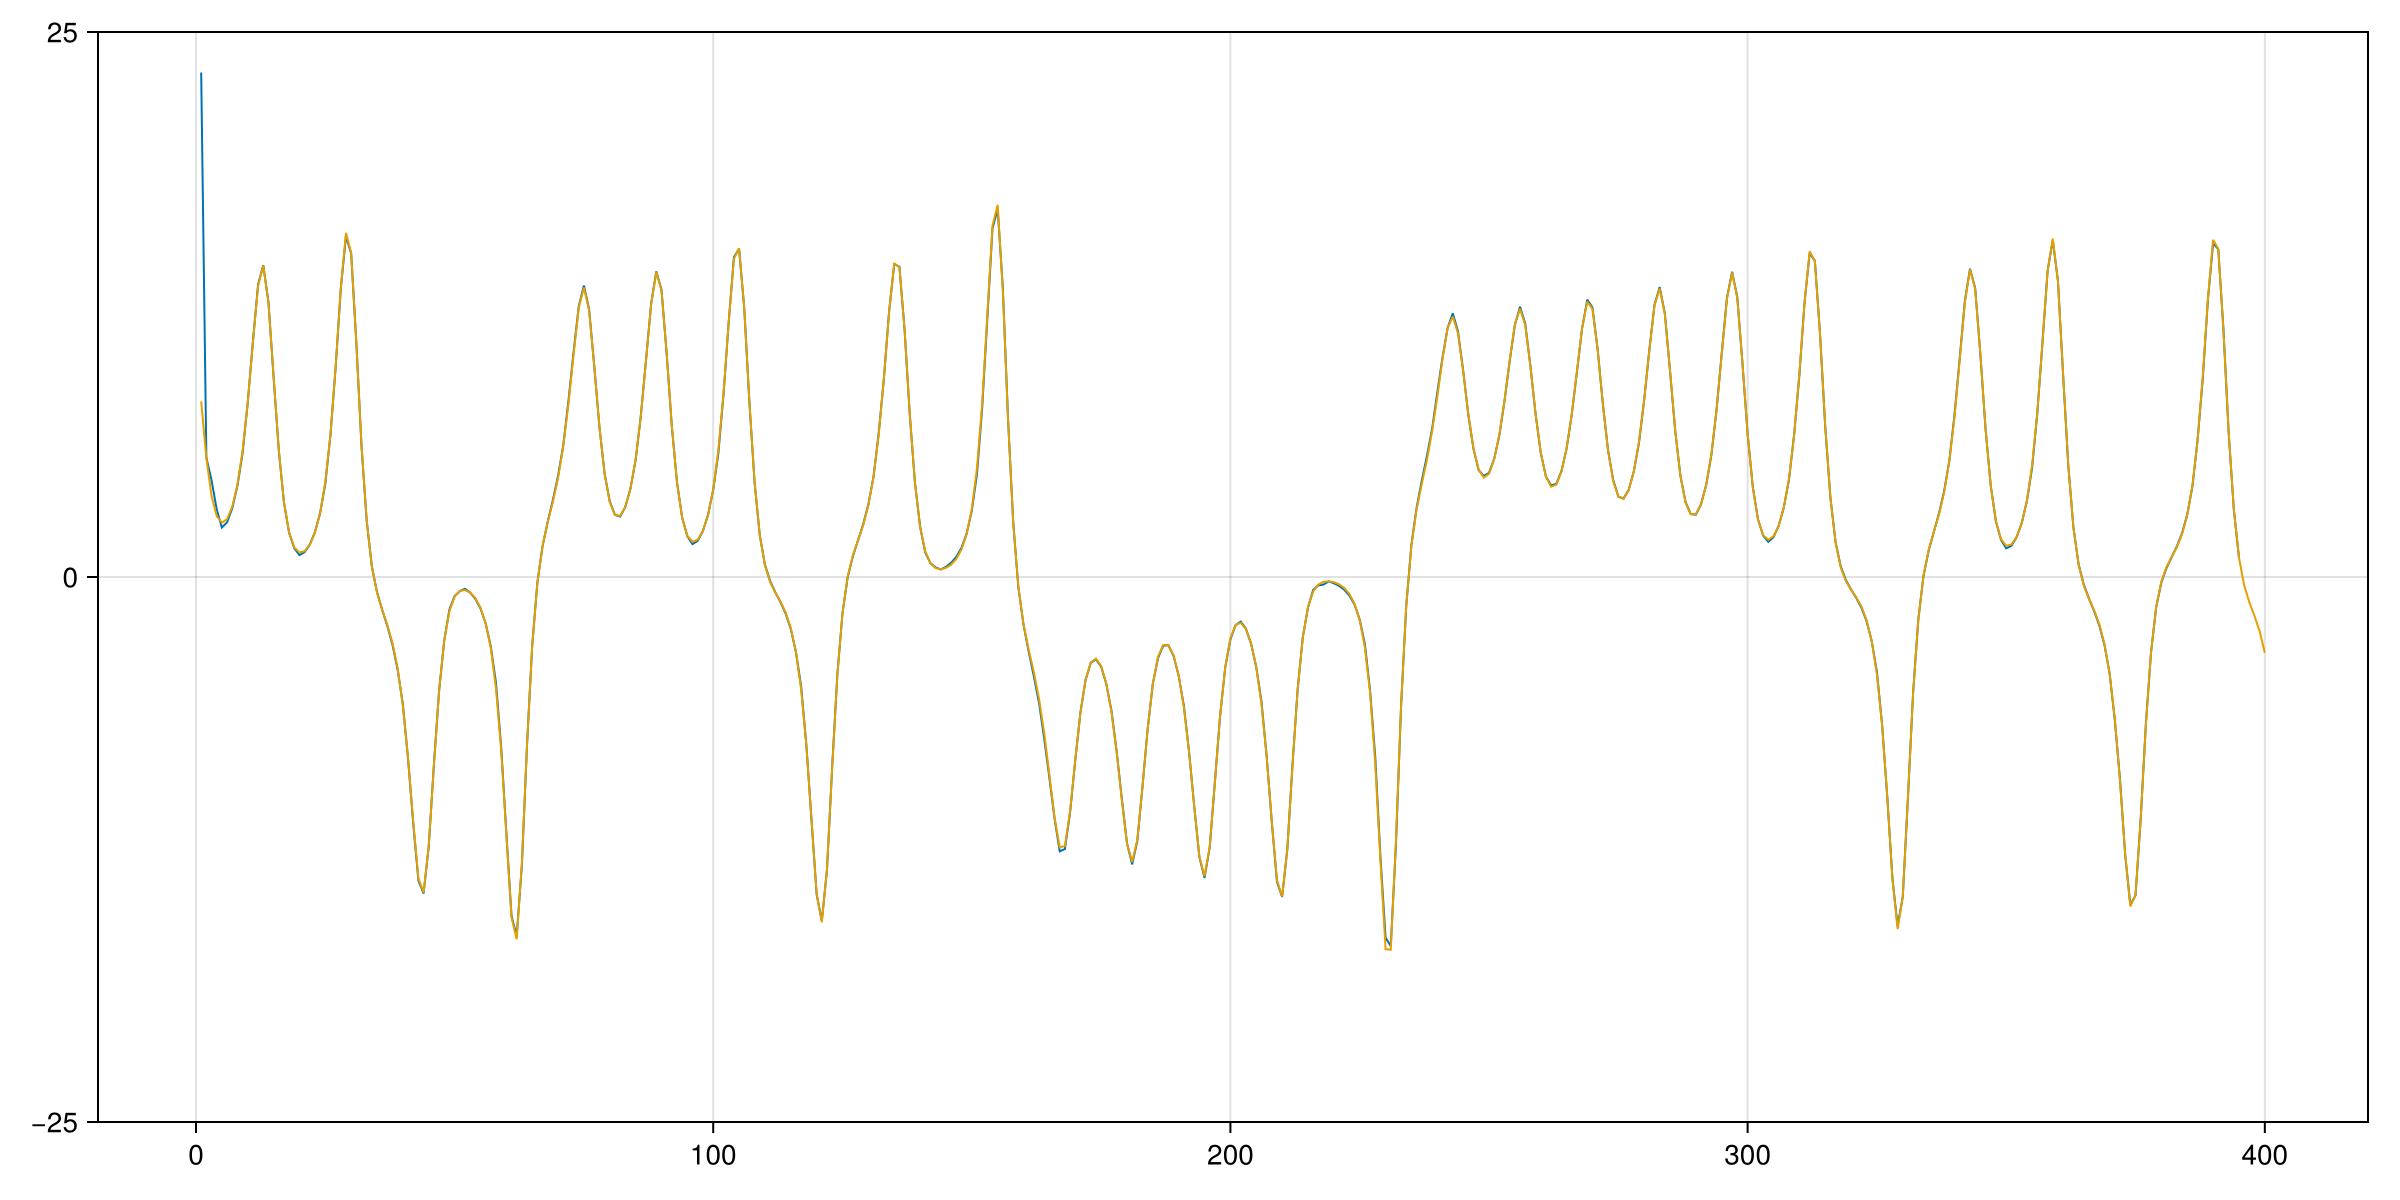

CairoMakie.Screen{IMAGE}


In [73]:
fig = Figure( size = (1200,600) )
ax1 = Axis(fig[1,1])
lines!(ax1, switching_pred; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
# xlims!(0,200)
ylims!(-25,25)
display(fig)

Seems to do better with fewer nodes. Has issue with turning points, see worse prediction around each turning point.

# State Switching

In [81]:
ESN_params.k
length(lo_test)

401

In [79]:
test_states

401×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.464519  0.419038  0.973588  …   0.667589   -0.710947   -0.388007
 0.511001  0.599965  0.962256      0.606629   -0.0683215  -0.228795
 0.512746  0.673301  0.969947      0.449374    0.192296   -0.309607
 0.496682  0.710402  0.971132      0.311407    0.366166   -0.344705
 0.488528  0.730231  0.972175      0.231685    0.443335   -0.365987
 0.485827  0.738537  0.97274   …   0.205967    0.465289   -0.371514
 0.487589  0.738746  0.973103      0.223095    0.449104   -0.36633
 0.492839  0.732141  0.973363      0.27721     0.397522   -0.351515
 0.501612  0.718037  0.973569      0.367824    0.300919   -0.32594
 0.514582  0.693903  0.973708      0.493712    0.139862   -0.286513
 0.532339  0.655825  0.973683  …   0.640712   -0.100067   -0.230029
 0.553694  0.601583  0.973274      0.773524   -0.381256   -0.159035
 0.573734  0.540945  0.972194      0.855468   -0.592548   -0.0934955
 ⋮                             ⋱                          
 

In [ ]:
m = 3
w = 1
τ = 3

part = create_ordinal_partition(lo_train, m, w, τ)
part_symbols = [findfirst(==(row), unique(eachrow(part))) for row in eachrow(part)]
unique_partitions = unique(eachrow(part))

Rs = Matrix(undef, length(unique(eachrow(part))), ESN_params.k)

for i in 1:length(unique(eachrow(part)))
    part_mask = [part_symbols .== i; fill(false, 6)]
    R, train_states = train_one_step_pred_with_mask(lo_train, ESN_params, part_mask)
    Rs[i, :] = R
end

preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs)
switching_pred = switch_prediction(lo_test, preds, unique_partitions)